In [128]:
import numpy as np
import pandas as pd
import scipy as sc
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution


In [2]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack', process_cohorts=False):
    # method: PCA
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    cohorts = df.batch_number.unique().tolist()
    ind = df.index
    non_gene_columns = [_col for _col in df.columns if 'GenX' not in _col]
    red_data_dict = {}
    if process_cohorts:
        for _cohort in cohorts:
            ch = df['batch_number']==_cohort
            X = df.loc[ch, gene_columns]
            if X.shape[0]>min_samples:
                # PCA 3
                reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
                # put components in a dictionary with cohort as key
                X_red = reducer.fit_transform(X)
                #
                red_data_dict[_cohort] = {}
                red_data_dict[_cohort]['data'] = X_red
                red_data_dict[_cohort]['reducer'] = reducer
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    
    red_cols = ['red_'+str(i) for i in range(0,n_comp)]
    df_red = pd.DataFrame(data=X_red, index=ind, columns=red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df[non_gene_columns].merge(df_red, how='inner', left_index=True, right_index=True)
    red_data_dict['ALL']['reducer'] = reducer
    
    
    return red_data_dict

In [3]:
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

# significances of differences between pheno's.
def distribution_difference_phenotypes(df, batches=[], phenotypes=[]):
    tot_res = []
    for _phenotype in phenotypes:    
        res = []
        for _batch_nr in batches:
            _all = df.loc[df.batch_number!=_batch_nr][_phenotype]
            _batch = df.loc[df.batch_number==_batch_nr][_phenotype]
            _ks = ks2(_all.values, _batch.values)
            _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
            try:
                _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
                _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            except ValueError as e:
                print('ValError, defaulting to NaN')
                _w1 = _w2 = np.nan

            res.append({'batch_number': _batch_nr,
                        'ks_stat': _ks[0], 'ks_p': _ks[1],
                        'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                        'w1_dist': _w1, 'w2_dist': _w2})
        res_df = pd.DataFrame(res)
        tot_res.append({_phenotype: res_df})
    return tot_res

def _cohort_bias_metrics_colwise_reduced(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


# Load in data

In [6]:
# "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung"
# "/home/bramiozo/DATA/LungCancerResearch/" 
source_dir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/"
RNA_ComBat_param = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_param.csv",
                               sep="\t", engine="python")
#RNA_ComBat_param.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_param.columns.tolist()]
#RNA_ComBat_param.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_param.index.tolist()]
###
RNA_ComBat_nonparam = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                               sep="\t", engine="python")
#RNA_ComBat_nonparam.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_nonparam.columns.tolist()]
#RNA_ComBat_nonparam.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_nonparam.index.tolist()]
###
#RNA_LSquantile = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_quantile_LS_.csv"
#                                    , sep=",", engine="python")
###
RNA_Raw = pd.read_csv(source_dir+"_prepped/gene_raw.csv", 
                      sep="\t", 
                      engine="python")
# RNAexpression_LSstandard_shifted
RNA_LSstandard = pd.read_csv(source_dir+"_prepped/RNAexpression_LSstandard_shifted.csv"
                                    , sep=",", engine="python")

In [9]:
#RNA_ComBat_param.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)
#RNA_ComBat_nonparam.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)

RNA_LSstandard.set_index('patient_nr', inplace=True)
#RNA_LSquantile.set_index('patient_nr', inplace=True)
RNA_Raw.set_index('GenX', inplace=True)
RNA_ComBat_nonparam.set_index('GenX', inplace=True)
RNA_ComBat_param.set_index('GenX', inplace=True)

TCGA_COLS = [_col for _col in RNA_ComBat_param.columns.tolist() if 'TCGA-' in _col]
RNA_ComBat_param = RNA_ComBat_param.copy().loc[:, TCGA_COLS]

TCGA_COLS = [_col for _col in RNA_ComBat_nonparam.columns.tolist() if 'TCGA-' in _col]
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().loc[:, TCGA_COLS]

# Add phenotypical data and transpose if necessary

In [10]:
RNA_Raw = RNA_Raw.copy().T
gc.collect()
RNA_ComBat_param = RNA_ComBat_param.copy().T
gc.collect()
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().T
gc.collect()

0

In [11]:
RNA_Raw.columns = ['GenX_'+_col for _col in RNA_Raw.columns.tolist()]
RNA_ComBat_param.columns = ['GenX_'+_col for _col in RNA_ComBat_param.columns.tolist()]
RNA_ComBat_nonparam.columns = ['GenX_'+_col for _col in RNA_ComBat_nonparam.columns.tolist()]

# load phenotypical data 

In [12]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']


In [13]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic
pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [14]:
#GenX_columns = [_col for _col in RNA_LSquantile.columns if 'GenX_' in _col]
#RNA_LSquantile = RNA_LSquantile.copy().loc[:, GenX_columns]
GenX_columns = [_col for _col in RNA_LSstandard.columns if 'GenX_' in _col]
RNA_LSstandard = RNA_LSstandard.copy().loc[:, GenX_columns]

In [15]:
data_dict = {'ComBat_param': RNA_ComBat_param, 
             'ComBat_nonparam': RNA_ComBat_nonparam,
             'LS_standard': RNA_LSstandard,
             #'LS_quantile': RNA_LSquantile,
             'raw': RNA_Raw}

In [16]:
for _key in data_dict.keys():
    data_dict[_key] = data_dict[_key].merge(pheno, how='left', left_index=True, right_index=True)

# Get principal components

In [17]:
data_reduced = {}
n_components = 50

for _key in data_dict.keys():
    print("Processing {} data: ".format(_key))
    data_reduced[_key] = _dim_reduction(data_dict[_key], min_samples=10, n_comp=n_components, method='PCA', pc_solver='arpack')

Processing ComBat_param data: 
Running reducer on all samples..
Processing ComBat_nonparam data: 
Running reducer on all samples..
Processing LS_standard data: 
Running reducer on all samples..
Processing raw data: 
Running reducer on all samples..


# Statistical analysis

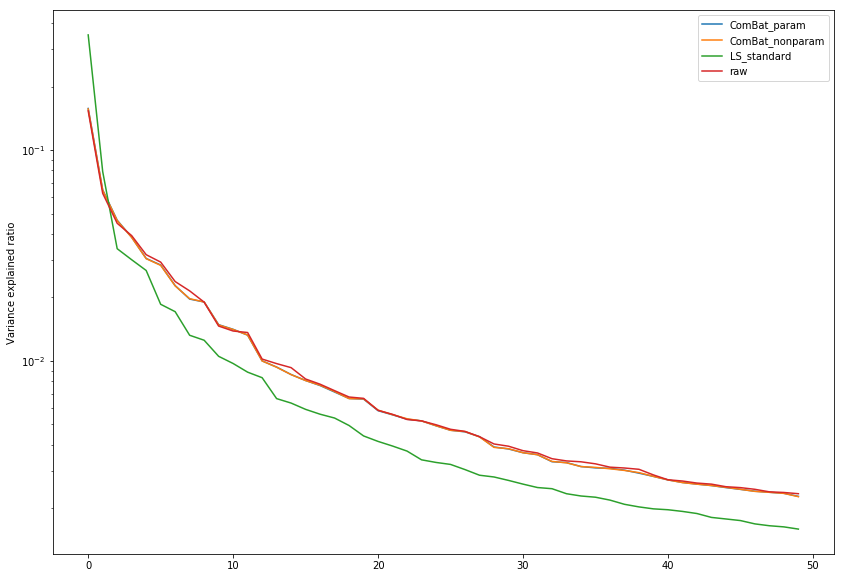

In [19]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

PC's for methylation data:ComBat_nonparam


Text(0.5,0.98,'ComBat_nonparam')

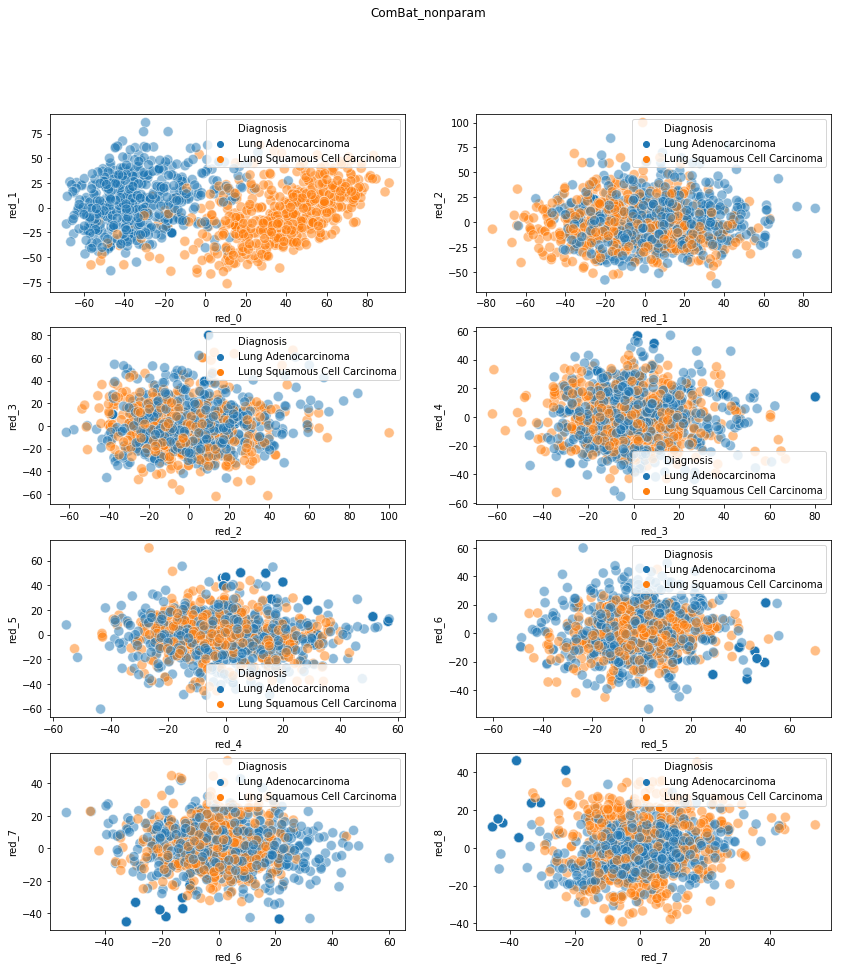

In [271]:
# check PCA, for first components, color by cancer diagnosis.
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(14,15))
key = 'ComBat_nonparam' # ComBat_param,ComBat_nonparam, LS_standard,raw
color_by = 'Diagnosis' # batch_number, Gender, Diagnosis
size_by = None
def_size = 100
style_by = None
print('PC\'s for methylation data:{}'.format(key))
sns.scatterplot(x='red_0', y='red_1', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_2', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_2', y='red_3', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_3', y='red_4', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_4', y='red_5', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_5', y='red_6', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_6', y='red_7', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_7', y='red_8', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
fig.suptitle(key)

We still see a very strong separation between the two diagnoses after the CBC-correction using ComBat.

What is the seperability of the two classes in the first principal components?

In [60]:
key = 'raw'  # 'ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'
red_cols = ['red_'+str(i) for i in range(0, n_components)]
score_list = []
for _key in data_reduced.keys():
    for idx, _red in enumerate(red_cols):
        scores = ks2(data1=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Adenocarcinoma'").loc[:,_red], 
           data2=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Squamous Cell Carcinoma'").loc[:,_red])
        
        score_list.append({'dim': _red, 
                           'dim_num': idx,
                           'score': scores[0],
                           'pval': scores[1], 
                           'set': _key})
score_df = pd.DataFrame(score_list)

Text(0.5,0.98,'Separability of cancer diagnoses')

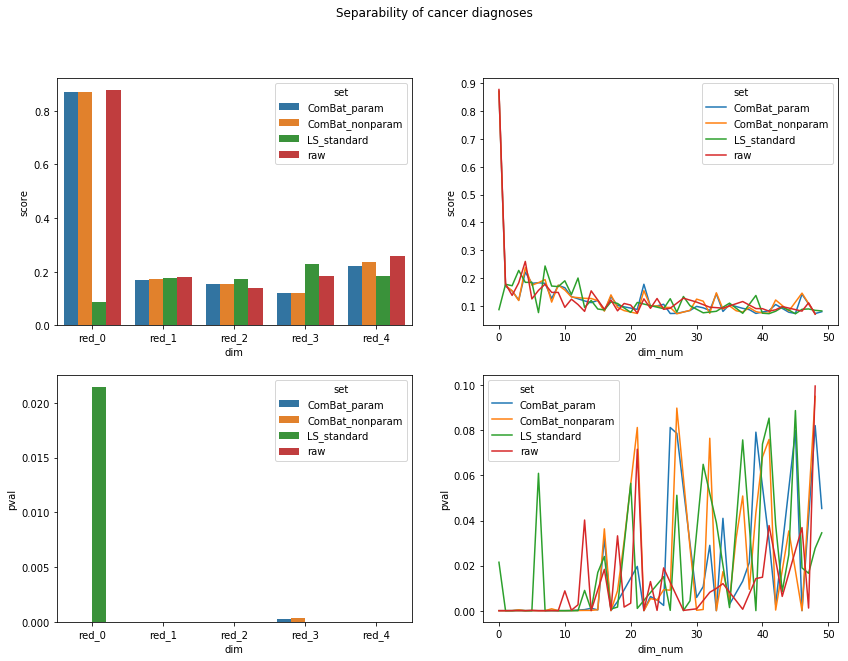

In [68]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

pval_min = 0.1

sns.barplot(x='dim', y='score', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4'])) &
                              (score_df.pval<pval_min)], ax=ax[0,0])
sns.lineplot(x='dim_num', y='score', hue='set', 
             data=score_df.loc[score_df.pval<pval_min], ax=ax[0,1])
sns.barplot(x='dim', y='pval', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4'])) &
                              (score_df.pval<pval_min)], ax=ax[1,0])
sns.lineplot(x='dim_num', y='pval', hue='set', 
             data=score_df.loc[score_df.pval<pval_min], ax=ax[1,1])
fig.suptitle('Separability of cancer diagnoses')

# Batch dissimilarity

Processing ds: ComBat_param
Processing ds: ComBat_nonparam
Processing ds: LS_standard
Processing ds: raw


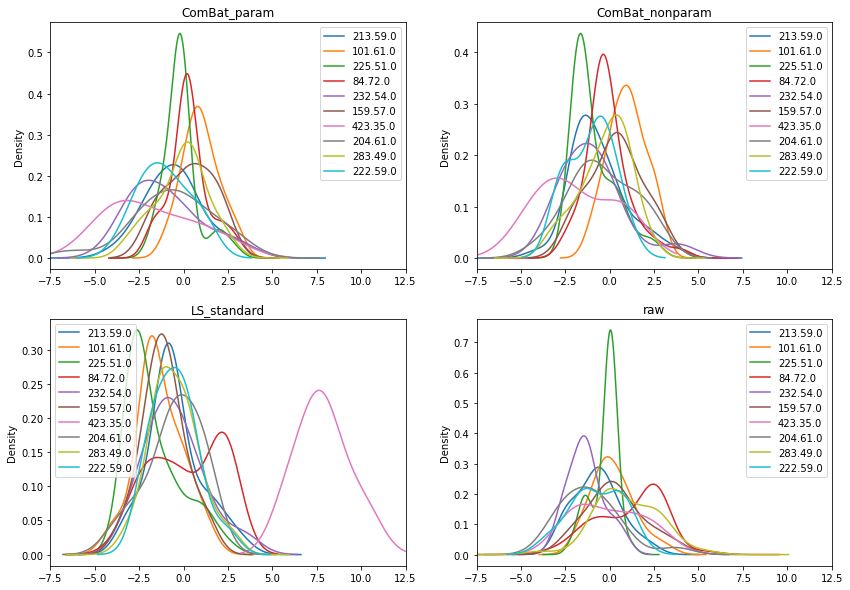

In [74]:
num_test_batches = 10

num_of_batches=data_dict['raw']['batch_number'].nunique()
batches = data_dict['raw']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches = batches[batch_indices].tolist()


Processing ds: ComBat_param
Processing ds: ComBat_nonparam
Processing ds: LS_standard
Processing ds: raw


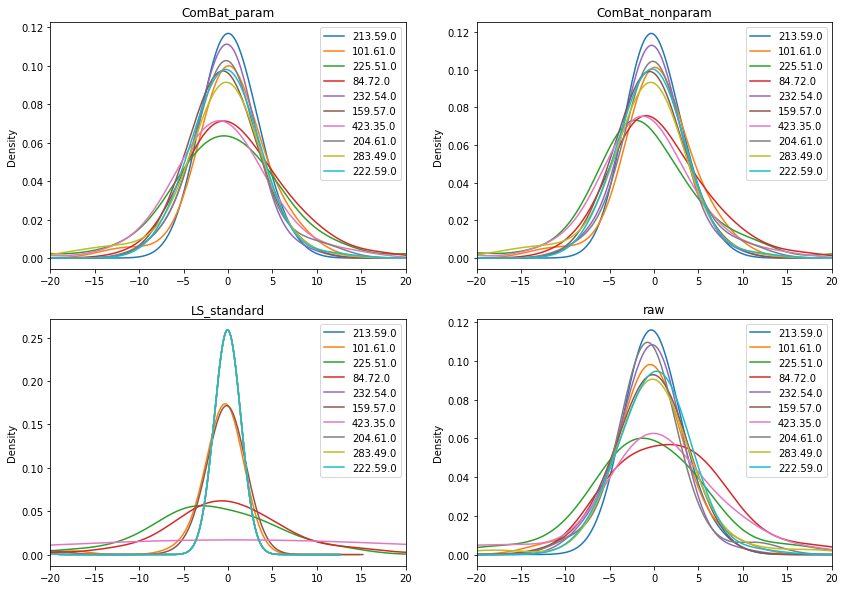

In [87]:
data_set = 'raw' # 'ComBat_param', 'LS_standard', 'raw', 'ComBat_nonparam'
data_type = 'reduced' # original, reduced
axc = 0 # 0: distribution of the mean probe values over the samples, 1: mean sample values over the probes
xr = -20, 20
num_sets = len(data_dict.keys())
fig, ax = plt.subplots(nrows=int(np.ceil(num_sets/2)), ncols=2, figsize=(14,10))
for rdx, _dkey in enumerate(data_dict.keys()):   
    print("Processing ds: {}".format(_dkey))
    for cdx, _batch in enumerate(test_batches):
        #print('Batch: {}'.format(_batch))
        rn = int(np.floor(rdx/2))
        cn = rdx%2
        if data_type == 'original':
            GenX_columns = [_col for _col in data_dict[_dkey].columns if 'GenX_' in _col]
            data_dict[_dkey].query('batch_number=="'+str(_batch)+'"').loc[:,GenX_columns]\
                                                                     .mean(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rn, cn])
        else:
            Red_columns = [_col for _col in data_reduced[_dkey]['ALL']['data'].columns if 'red_' in _col]
            data_reduced[_dkey]['ALL']['data'].query('batch_number=="'+str(_batch)+'"').loc[:,Red_columns]\
                                                                     .mean(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rn, cn])            
        
        ax[rn, cn].set_xlim(xr[0], xr[1])
        ax[rn, cn].set_title(_dkey)
        ax[rn, cn].legend()

In [89]:
batch_list = pheno.batch_number.unique().tolist()

In [ ]:
# Sample wise comparison
# get number of batches that are significantly different from the rest
# overall distribution of KS-scores

In [218]:
#key = 'raw'  # 'ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'
red_cols = ['red_'+str(i) for i in range(0, n_components)]
score_list = []
sign_tests = ['ks', 'mwu']
# one-batch v. the rest
def get_sign_test_reduced(data_reduced, batch_list):
    for _test in sign_tests:
        print("Stat test : {}".format(_test))
        for _batch in tqdm(batch_list):
            for _key in data_reduced.keys():
                for idx, _red in enumerate(red_cols):
                    if _test == 'ks':
                        scores = ks2(data1=data_reduced[_key]['ALL']['data'].query("batch_number=='"+str(_batch)+"'").loc[:,_red], 
                           data2=data_reduced[_key]['ALL']['data'].query("batch_number!='"+str(_batch)+"'").loc[:,_red])
                    elif _test =='mwu':
                        scores = mwu(x=data_reduced[_key]['ALL']['data'].query("batch_number=='"+str(_batch)+"'").loc[:,_red], 
                           y=data_reduced[_key]['ALL']['data'].query("batch_number!='"+str(_batch)+"'").loc[:,_red])                
                    score_list.append({'dim': _red, 
                                       'dim_num': idx,
                                       'score': scores[0],
                                       'pval': scores[1], 
                                       'set': _key, 
                                       'test': _test,
                                       'batch': _batch})
    return pd.DataFrame(score_list)

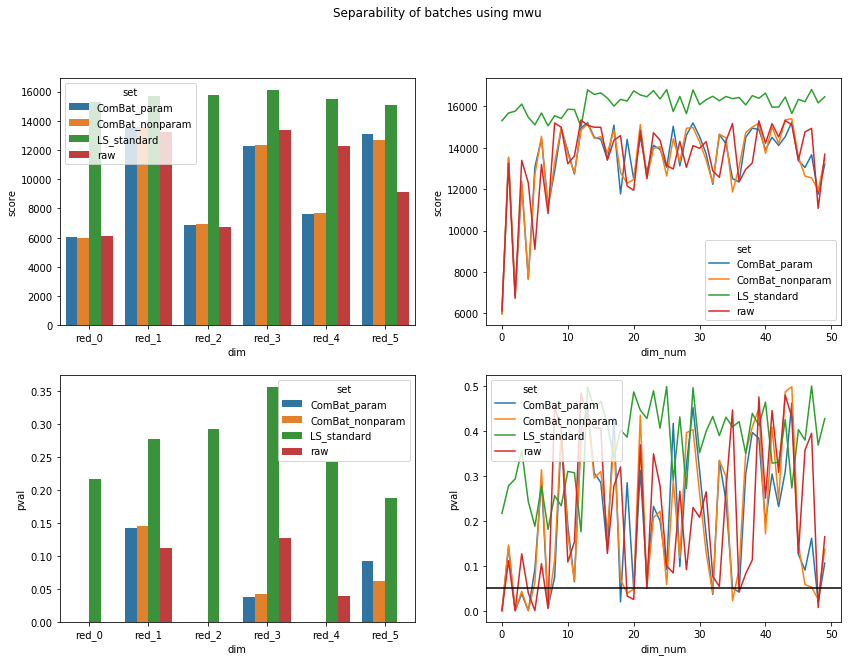

In [173]:
score_df = get_sign_test(data_reduced, batch_list)

pval_min = 1.
plot_batch = batch_list[7]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

sign_test = 'mwu'  # mw-u
sns.barplot(x='dim', y='score', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'red_5'])) &
                              (score_df.test==sign_test) & 
                              (score_df.pval<pval_min) & 
                              (score_df.batch==plot_batch)], ax=ax[0,0])
sns.lineplot(x='dim_num', y='score', hue='set', 
             data=score_df.loc[(score_df.pval<pval_min)  & 
                               (score_df.test==sign_test) & 
                              (score_df.batch==plot_batch)], ax=ax[0,1])
sns.barplot(x='dim', y='pval', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'red_5'])) &
                              (score_df.test==sign_test) & 
                              (score_df.pval<pval_min) & 
                              (score_df.batch==plot_batch)], ax=ax[1,0])
sns.lineplot(x='dim_num', y='pval', hue='set', 
             data=score_df.loc[(score_df.pval<pval_min)  & 
                               (score_df.test==sign_test) &
                               (score_df.batch==plot_batch)], ax=ax[1,1])
ax[1,1].axhline(0.05, color='black')
fig.suptitle('Separability of batches using {}'.format(sign_test))
plt.show()

  0%|          | 0/43 [00:00<?, ?it/s]

Stat test : ks


 12%|█▏        | 5/43 [00:03<00:27,  1.38it/s]/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4774: RuntimeWarning: invalid value encountered in true_divide
  cdf1 = np.searchsorted(data1, data_all, side='right') / (1.0*n1)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4780: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
  0%|          | 0/43 [00:00<?, ?it/s]

Stat test : mwu


 12%|█▏        | 5/43 [00:04<00:31,  1.21it/s]/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
100%|██████████| 43/43 [00:33<00:00,  1.35it/s]


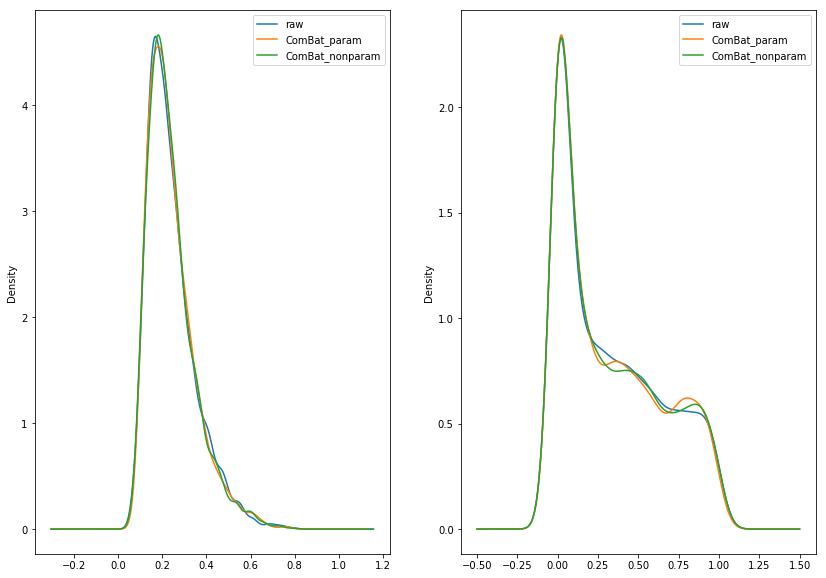

In [241]:
score_df = get_sign_test_reduced(data_reduced, batch_list)

fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df.query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df.query('set=="ComBat_param"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df.query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df.query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df.query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df.query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()


In [178]:
sign_test = 'mwu'
pval_min = 0.01
dim = 0
dset = 'ComBat_nonparam' # raw, ComBat_param, ComBat_nonparam
# 
(score_df.query('dim_num=='+str(dim)).query('set=="'+dset+'"').query('test=="'+sign_test+'"').pval<pval_min).sum()

40

Based on KS and MWU tests for each batch-versus-rest the CBC has not incurred a significant change. This could simply mean that there was little cohort-bias to begin with and that the difference is primarily caused by the covariants
and differences in the distribution of the value of interest. Note: cohort bias implies that the cohorts are statistically different over the cohorts, this does not mean that all inter-cohort differences are due to bias. 

We can observe from the PCA-plots that gender is not a strong separator and the cancer type clearly is.

In [184]:
pheno.columns

Index(['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis',
       'Age At Diagnosis (Days)', 'batch_number', 'histological_type',
       'cigarettes_per_day.exposures', 'tissue_or_organ_of_origin.diagnoses',
       'race.demographic', 'Diagnosis_num'],
      dtype='object')

In [191]:
pheno['Diagnosis_num'] = pheno['Diagnosis'].apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
pheno['Gender_num'] = pheno['Gender'].apply(lambda x: 0 if x=='male' else 1)

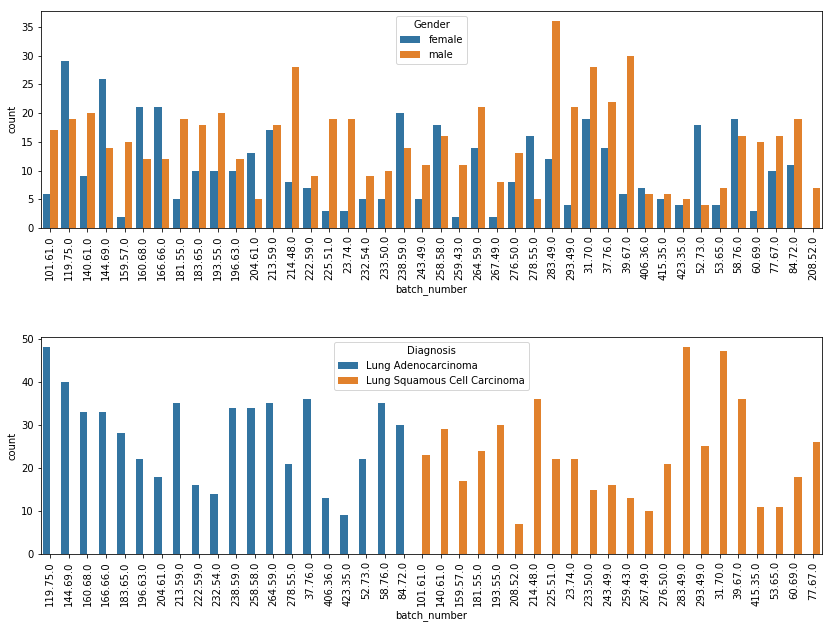

In [213]:
fig, ax = plt.subplots(nrows=2, figsize=(14,10))

pheno_plot = pheno.groupby(['Diagnosis', 'batch_number']).size().reset_index()
pheno_plot.columns=['Diagnosis', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Diagnosis', data=pheno_plot, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

pheno_plot = pheno.groupby(['Gender', 'batch_number']).size().reset_index()
pheno_plot.columns=['Gender', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Gender', data=pheno_plot, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

fig.subplots_adjust(hspace=0.5)

I.e. to perform the batch effect test we should seperate the batches based on the cancer diagnosis.

In [220]:
LA_batches = pheno.query('Diagnosis=="Lung Adenocarcinoma"').batch_number.unique().tolist()
LSCC_batches = pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"').batch_number.unique().tolist()

  0%|          | 0/20 [00:00<?, ?it/s]

Stat test : ks


  0%|          | 0/20 [00:00<?, ?it/s]

Stat test : mwu


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


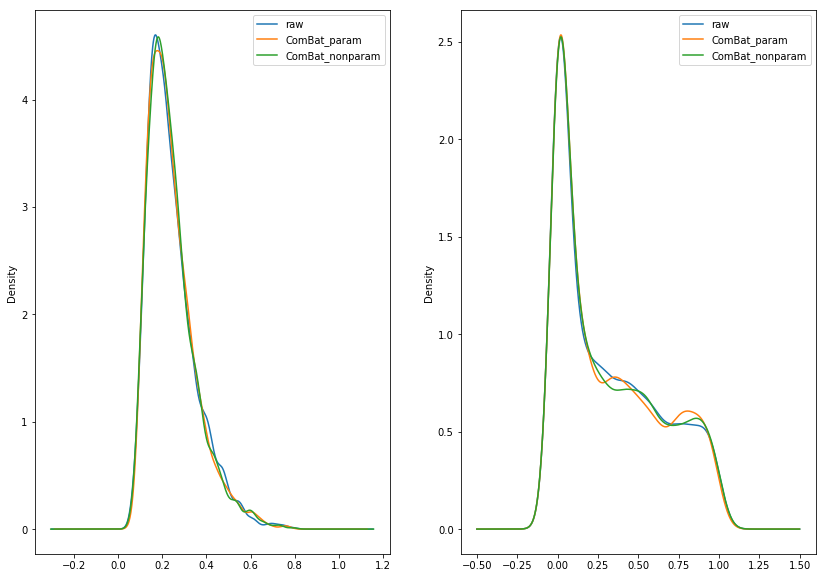

In [246]:
score_df_LA = get_sign_test_reduced(data_reduced, LA_batches)


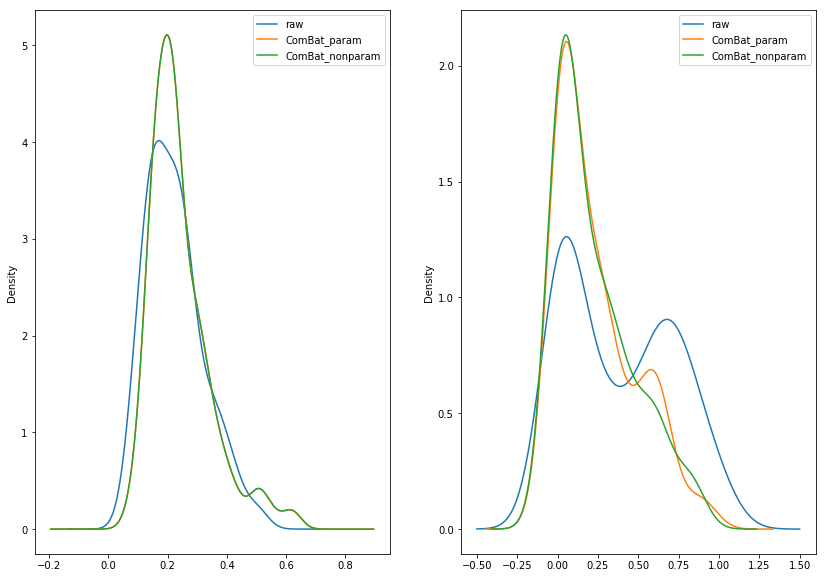

In [265]:
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df_LA.query('dim_num==7').query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df_LA.query('dim_num==7').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df_LA.query('dim_num==7').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df_LA.query('dim_num==7').query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df_LA.query('dim_num==7').query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df_LA.query('dim_num==7').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()

  0%|          | 0/22 [00:00<?, ?it/s]

Stat test : ks


  0%|          | 0/22 [00:00<?, ?it/s]

Stat test : mwu


100%|██████████| 22/22 [00:16<00:00,  1.29it/s]


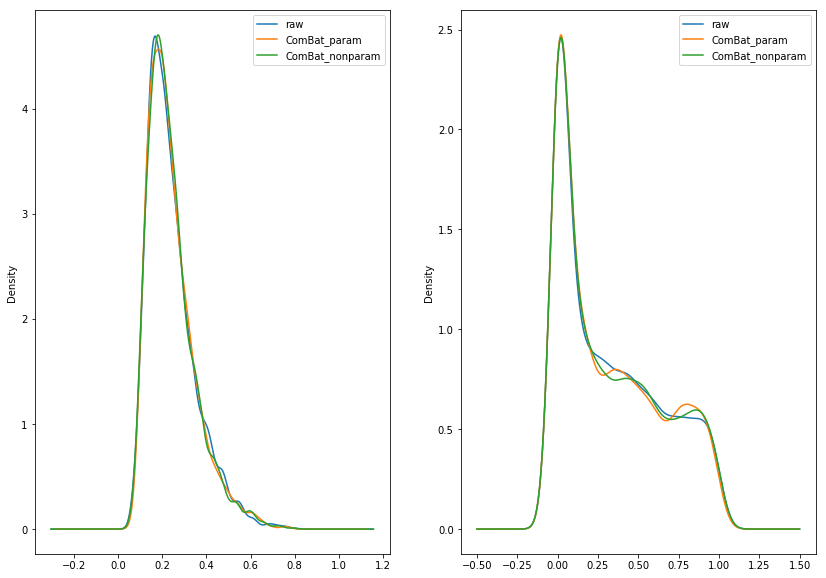

In [247]:
score_df_LSCC = get_sign_test_reduced(data_reduced, LSCC_batches)

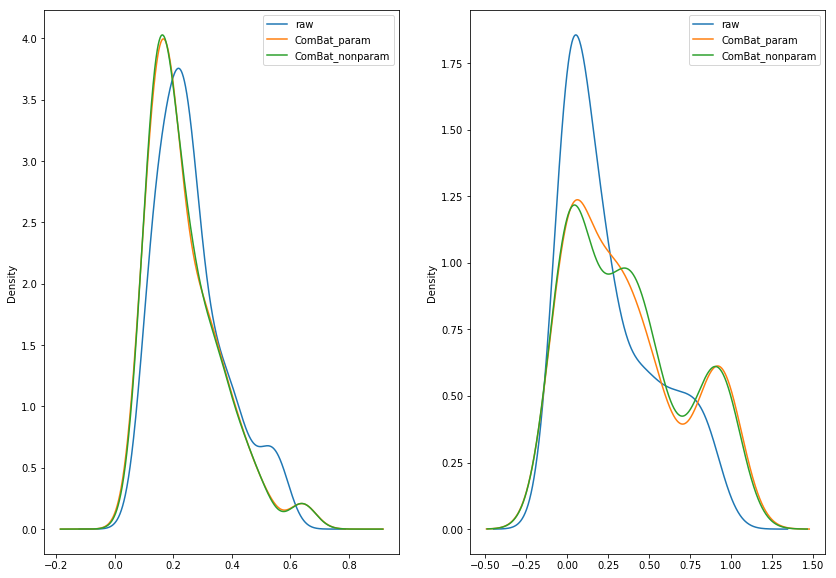

In [264]:
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df_LSCC.query('dim_num==3').query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_param"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df_LSCC.query('dim_num==3').query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()

Concluding, the CBC has only affected a few batches (most notably in the first, third, fourth and fifth principal components) that contain Lung Adenocarcinoma samples and has not significantly reduced the separability of the cancer types.

In [273]:
data_dict.keys()

dict_keys(['ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'])

In [292]:
class fs_mannwhitney():
    pvalue = 0.01
    p_values = None

    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        _, p_value = mannwhitneyu(pos[:,column], neg[:,column], alternative="less")
        return p_value

    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.p_values = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

In [293]:
def get_filtered_genomes(x, y, Rclass = None):
    try:
        alpha = Rclass.PIPELINE_PARAMETERS['feature_selection']['pvalue']
        filter_type = Rclass.PIPELINE_PARAMETERS['feature_selection']['method']
        F_function =  Rclass.PIPELINE_PARAMETERS['feature_selection']['score_function']
    except Exception as e:
        print("Exception with {} handling the function get_filtered_genomes".format(e))
        alpha = 0.05
        filter_type = 'FDR'
        F_function = 'ANOVA'    
    
    #  Mann-Whitney, between classes
    # scipy.stats.mannwhitneyu, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    if filter_type == 'mannwhitney':
        Selector = fs_mannwhitney(pvalue = alpha).fit(x,y)
        x_out = Selector.transform(x)[0]
    elif filter_type == 'FDR':
    # Use FDR with a number of different statistical measures:
    # f_classif, chi2, 
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(alpha = alpha, score_func = FDR_function) #f_classif, chi2
        Selector = FDR.fit(x, y)
        x_out = FDR.transform(x)
    elif filter_type == 'FPR':
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFpr(alpha = alpha, score_func = FPR_function) #f_classif, chi2
        Selector = FPR.fit(x, y)
        x_out = FPR.transform(x)        

    return x_out, Selector

In [291]:
#@jit('int32[:](float64[:,:], int32[:]))
def get_differential_probes(x, y,  method='FDR', n_top = 10, **kwargs):
    '''
     x : array (samples x probes)
     y : array (target values)
     method : FDR/MWU/KS 
     n_top : number of top discriminating probes 
     kwargs: arguments for stat method
     
     return: index array of top n discriminators
    '''
        
    # loop through columns
    
    # apply stat test 
    
    
    return 

In [287]:
genx_cols = [_col for _col in data_dict['raw'].columns if 'GenX' in _col]
y = data_dict['raw']['Diagnosis'].apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
x = data_dict['raw'].loc[:,genx_cols].values

top_probes = get_differential_probes(x, y, method='FDR', n_top=10)

In [317]:
[_col for _col in data_dict['raw'].columns.tolist() if 'EGFR' in _col]

['GenX_EGFR.chr7.55019021.55256620.+',
 'GenX_EGFR-AS1.chr7.55179750.55188934.-']

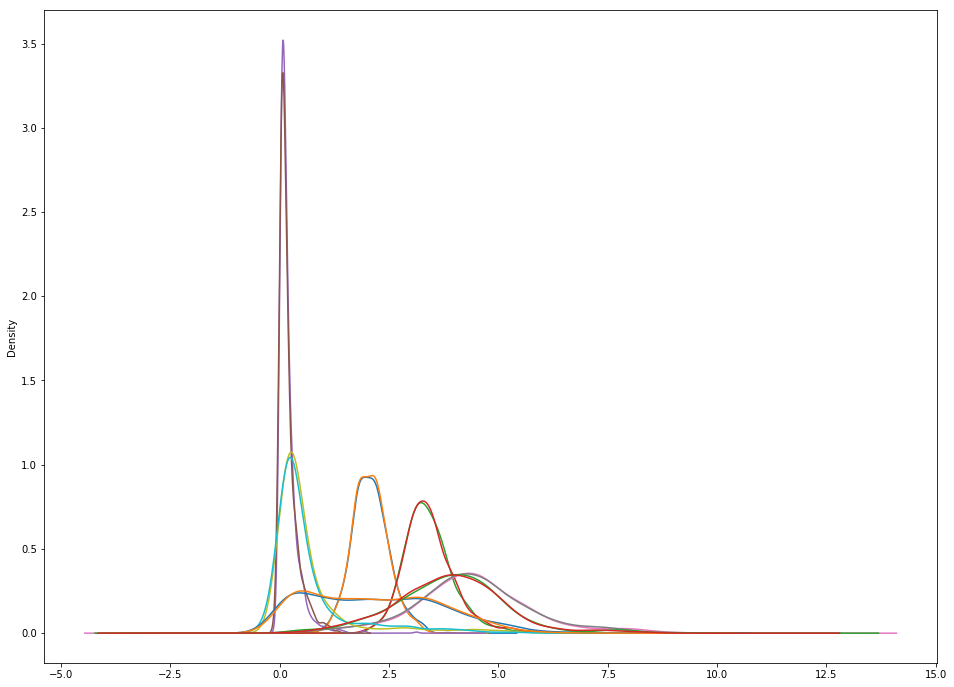

In [320]:
data_dict['raw']['GenX_BRAF.chr7.140719327.140924764.-'].plot.kde(figsize=(16,12)) # 
data_dict['ComBat_nonparam']['GenX_BRAF.chr7.140719327.140924764.-'].plot.kde()

data_dict['raw']['GenX_KRAS.chr12.25204789.25250936.-'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_KRAS.chr12.25204789.25250936.-'].plot.kde()

data_dict['raw']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde()

data_dict['raw']['GenX_MET.chr7.116672390.116798386.+'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_MET.chr7.116672390.116798386.+'].plot.kde()

data_dict['raw']['GenX_RET.chr10.43077027.43130351.+'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_RET.chr10.43077027.43130351.+'].plot.kde()

data_dict['raw']['GenX_ROS1.chr6.117288300.117425855.-'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_ROS1.chr6.117288300.117425855.-'].plot.kde()

data_dict['raw']['GenX_EGFR.chr7.55019021.55256620.+'].plot.kde() # 
data_dict['ComBat_nonparam']['GenX_EGFR.chr7.55019021.55256620.+'].plot.kde()